In [92]:
from json import load
from re import S
import pyfmi
import os
import numpy as np
from random import uniform
import random
import matplotlib.pyplot as plt
import pandas as pd
import glob
import copy

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

# define model

In [3]:
torch.set_printoptions(precision=8)
torch.autograd.set_detect_anomaly(True)
random.seed(10000)
np.random.seed(10000)
torch.manual_seed(10000)
loss_logp_fn=nn.GaussianNLLLoss()

In [97]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
if device == "cuda":
    torch.cuda.empty_cache()


# Define model
class NeuralNetwork(nn.Module):
    def __init__(self, internal_layers=1, hidden_dim=8, input_dim=18, output_dim=2, dropout=0.2):
        super(NeuralNetwork, self).__init__()
        self.internal_layers = internal_layers  # num of layers for each LSTM
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim  # dim of hidden states
        self.output_dim = output_dim
        self.dropout = dropout

        self.RNN1 = nn.LSTM(self.input_dim, self.hidden_dim, self.internal_layers, batch_first=True,
                            dropout=self.dropout).double()
        self.linear1 = nn.Linear(self.hidden_dim, self.output_dim).double()
        self.hidden1 = self.init_hidden()  # initialize hidden states at 0

    def forward(self, x, initial_hidden=False, trim=False):
        if initial_hidden:
            self.hidden1 = self.init_hidden(size=x.batch_sizes[0])

        if trim:
            self.hidden1 = self.trim_hidden(size=x.batch_sizes[0])

        x, self.hidden1 = self.RNN1(x, self.hidden1)
        self.hidden1 = (self.hidden1[0].detach(), self.hidden1[1].detach())
        x = self.squash_packed(x, fn=self.linear1)

        return x

    def init_hidden(self, size=64):
        # Before training, we dont have any hidden state.
        # Dim of hidden states: (num of layers, size of batch(batchsize), length of hidden state of RNN cell)
        return (torch.zeros(self.internal_layers, size, self.hidden_dim).double().detach().to(device),
                torch.zeros(self.internal_layers, size, self.hidden_dim).double().detach().to(device))

    def trim_hidden(self, size=64):
        # hidden state transmit among batches, size of last batch might differ from that of next batch, so hidden state need to be trimmed.
        # Dim of hidden states: (num of layers, size of batch(batchsize), length of hidden state of RNN cell)
        self.hidden1 = (self.hidden1[0][:, :size, :], self.hidden1[1][:, :size, :])
        # print(self.hidden1.shape)

    def init_hidden_olayer(self, size=64):
        # last layer has different dim for hidden states.
        return (torch.zeros(self.internal_layers, size, self.output_dim).double().detach().to(device),
                torch.zeros(self.internal_layers, size, self.output_dim).double().detach().to(device))

    def squash_packed(self, x, fn=nn.functional.relu):
        return torch.nn.utils.rnn.PackedSequence(fn(x.data), x.batch_sizes,
                                                 x.sorted_indices, x.unsorted_indices)


Using cuda device


# load data

In [98]:
new_scope = 2
new_min = -1

inputs_variable = ['payloadFraction', 'steer11', 'brakePosition[percent]', 'wheelspeed', 'resFrontVx[Km_per_h]',
                   'resFrontVy[Km_per_h]', 'resRearVx[Km_per_h]', 'resRearVy[Km_per_h]', 'resFrontYWRT[d/s]',
                   'resFrontRRT[d/s]', 'resFrontPRT[d/s]', 'resRearYWRT[d/s]', 'resRearRRT[d/s]', 'resRearPRT[d/s]',
                   'resFrontACLNY[g]', 'resFrontACLNX[g]', 'resRearACLNY[g]', 'resRearACLNX[g]']

path = os.getcwd()
rnndata_path = os.path.abspath(os.path.join(path, os.pardir)) + '/data/04_rnn_learning_dataset'


def pd_to_torch(data):
    data=torch.from_numpy(data.values)
    return data


# *_yawrate and *_yawrate_difference is in the form of two dim torch with shape (len,1)
training_inputs=pd_to_torch(pd.read_csv(rnndata_path + '/training_inputs.csv'))
training_yawrate=pd_to_torch(pd.read_csv(rnndata_path + '/training_yawrate.csv'))
training_yawrate_difference=pd_to_torch(pd.read_csv(rnndata_path + '/training_yawrate_difference.csv'))
val_inputs=pd_to_torch(pd.read_csv(rnndata_path + '/val_inputs.csv'))
val_yawrate=pd_to_torch(pd.read_csv(rnndata_path + '/val_yawrate.csv'))
val_yawrate_difference=pd_to_torch(pd.read_csv(rnndata_path + '/val_yawrate_difference.csv'))
testing_inputs=pd_to_torch(pd.read_csv(rnndata_path + '/testing_inputs.csv'))
testing_yawrate=pd_to_torch(pd.read_csv(rnndata_path + '/testing_yawrate.csv'))
testing_yawrate_difference=pd_to_torch(pd.read_csv(rnndata_path + '/testing_yawrate_difference.csv'))

variable_property=pd.read_csv(rnndata_path + '/variable_property.csv')
variable_property.set_index(['Unnamed: 0'],inplace=True)


In [99]:
display(variable_property)

,payloadFraction,steer11,brakePosition[percent],wheelspeed,resFrontVx[Km_per_h],resFrontVy[Km_per_h],resRearVx[Km_per_h],resRearVy[Km_per_h],resFrontYWRT[d/s],resFrontRRT[d/s],resFrontPRT[d/s],resRearYWRT[d/s],resRearRRT[d/s],resRearPRT[d/s],resFrontACLNY[g],resFrontACLNX[g],resRearACLNY[g],resRearACLNX[g]
Unnamed: 0,,,,,,,,,,,,,,,,,,
min,0.503654,-0.461006,0.000000,0.000000,-0.144849,-4.780836,-0.130160,-1.413721,-22.467990,-5.338305,-2.217603,-22.806950,-0.553923,-2.217772,-0.253633,-0.204266,-0.214350,-0.225332
max,0.681154,0.491510,0.507082,21.447968,76.778864,4.909317,76.761414,1.409242,24.630167,5.220643,2.318701,25.150288,0.424046,2.318701,0.248056,0.091848,0.255895,0.075689


evaluation on training set
evaluation on val set
evaluation on testing set


Text(0.5, 1.0, 'mse_fmu: tensor(0.30822780, dtype=torch.float64)mse_rnn: tensor(0.12728396, dtype=torch.float64)logp_rnn: tensor(-0.61622149, dtype=torch.float64)')

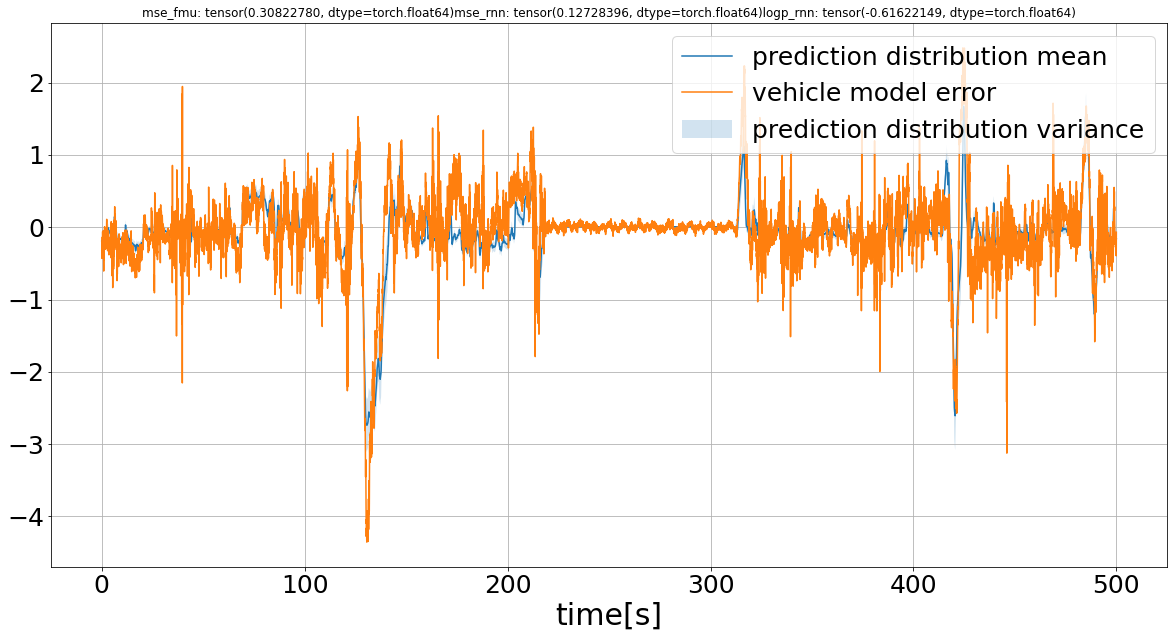

In [100]:
model = NeuralNetwork(internal_layers=2, hidden_dim=128, input_dim=18, output_dim=2,
                          dropout=0.2).to(device)
model.load_state_dict(torch.load(os.path.abspath(os.path.join(path, os.pardir)) + '/models/uncertainty_aware_batch/retrain_epoch_40target_difference_layers_2_nodes_128_dropout_0.2_batchsize_8_sequencelength_128_learningrate_0.01.pt'))

#fig,ax=plt.subplots(3,1,figsize=(20,40))
model.eval()


print('evaluation on training set')
inputs_ = [training_inputs]
res = model(torch.nn.utils.rnn.pack_sequence(inputs_, initial=True).to(device), initial_hidden=True).data.detach().cpu()
mu = res[:, 0]
sigma=torch.log(1 + torch.exp(res[:, 1]))
logp_rnn_training = loss_logp_fn(mu, training_yawrate_difference[:, 0], sigma)
mse_rnn_training= torch.mean(np.square(training_yawrate_difference[:, 0] - mu))
    
for v,variable in enumerate(inputs_variable):
    if variable=='resRearYWRT[d/s]':
        max_=variable_property.loc['max',variable]
        min_=variable_property.loc['min',variable]
        input_variable=(training_inputs[:,v]-new_min)/new_scope*(max_-min_)+min_
        mse_fmu_training= torch.mean(torch.square(training_yawrate[:,0] - input_variable))
#         #ax[0].plot(range(len(training_inputs)),input_variable,label=str(variable))
# #ax[0].plot(range(len(training_inputs)),training_yawrate,label='yawrate')
# ax[0].plot(range(len(training_inputs[:5000])),mu[:5000],label='RNN model')
# ax[0].fill_between(range(len(training_inputs[:5000])), mu[:5000] - sigma[:5000], mu[:5000] + sigma[:5000], alpha=0.2, label='one std interval')
# ax[0].plot(range(len(training_inputs[:5000])),training_yawrate_difference[:5000],label='error')
# ax[0].legend()
# ax[0].grid()
# ax[0].set_title('mse_fmu: '+str(mse_fmu_training)+'mse_rnn: '+str(mse_rnn_training)+'logp_rnn: '+str(logp_rnn_training))

print('evaluation on val set')
inputs_ = [val_inputs]
res = model(torch.nn.utils.rnn.pack_sequence(inputs_).to(device)).data.detach().cpu()
mu = res[:, 0]
sigma=torch.log(1 + torch.exp(res[:, 1]))
logp_rnn_val = loss_logp_fn(mu, val_yawrate_difference[:, 0], sigma)
mse_rnn_val= torch.mean(np.square(val_yawrate_difference[:, 0] - mu))
    
for v,variable in enumerate(inputs_variable):
    if variable=='resRearYWRT[d/s]':
        max_=variable_property.loc['max',variable]
        min_=variable_property.loc['min',variable]
        input_variable=(val_inputs[:,v]-new_min)/new_scope*(max_-min_)+min_
        mse_fmu_val= torch.mean(torch.square(val_yawrate[:,0] - input_variable))
#         #ax[1].plot(range(len(val_inputs)),input_variable,label=str(variable))
# #ax[1].plot(range(len(val_inputs)),val_yawrate,label='yawrate')
# ax[1].plot(range(len(val_inputs[:5000])),mu[:5000],label='RNN model')
# ax[1].plot(range(len(val_inputs[:5000])),val_yawrate_difference[:5000],label='error')
# ax[1].fill_between(range(len(val_inputs[:5000])), mu[:5000] - sigma[:5000], mu[:5000] + sigma[:5000], alpha=0.2, label='one std interval')
# ax[1].legend()
# ax[1].grid()
# ax[1].set_title('mse_fmu: '+str(mse_fmu_val)+'mse_rnn: '+str(mse_rnn_val)+'logp_rnn: '+str(logp_rnn_val))


plt.figure(figsize=(20,10))

print('evaluation on testing set')
inputs_ = [testing_inputs]
res = model(torch.nn.utils.rnn.pack_sequence(inputs_).to(device)).data.detach().cpu()
mu = res[:, 0]
sigma=torch.log(1 + torch.exp(res[:, 1]))
pd.DataFrame(mu.numpy()).to_csv(rnndata_path+'/uncertaintymodel_mu.csv')
pd.DataFrame(sigma.numpy()).to_csv(rnndata_path+'/uncertaintymodel_sigma.csv')
logp_rnn_testing = loss_logp_fn(mu, testing_yawrate_difference[:, 0], sigma)
mse_rnn_testing= torch.mean(np.square(testing_yawrate_difference[:, 0] - mu))
    
for v,variable in enumerate(inputs_variable):
    if variable=='resRearYWRT[d/s]':
        max_=variable_property.loc['max',variable]
        min_=variable_property.loc['min',variable]
        input_variable=(testing_inputs[:,v]-new_min)/new_scope*(max_-min_)+min_
        mse_fmu_testing= torch.mean(torch.square(testing_yawrate[:,0] - input_variable))
        #ax[2].plot(range(len(testing_inputs)),input_variable,label=str(variable))
#ax[2].plot(range(len(testing_inputs)),testing_yawrate,label='yawrate')
plt.plot(np.linspace(0,500,50000),mu[:50000],label='prediction distribution mean')
plt.plot(np.linspace(0,500,50000),testing_yawrate_difference[:50000],label='vehicle model error')
plt.fill_between(np.linspace(0,500,50000), mu[:50000] - sigma[:50000], mu[:50000] + sigma[:50000], alpha=0.2, label='prediction distribution variance')
plt.legend(loc='upper right', prop={'size': 25})
plt.grid()
plt.xlabel('time[s]',fontsize=30)
plt.tick_params(axis='x', labelsize=25)
plt.tick_params(axis='y', labelsize=25)
plt.title('mse_fmu: '+str(mse_fmu_testing)+'mse_rnn: '+str(mse_rnn_testing)+'logp_rnn: '+str(logp_rnn_testing))




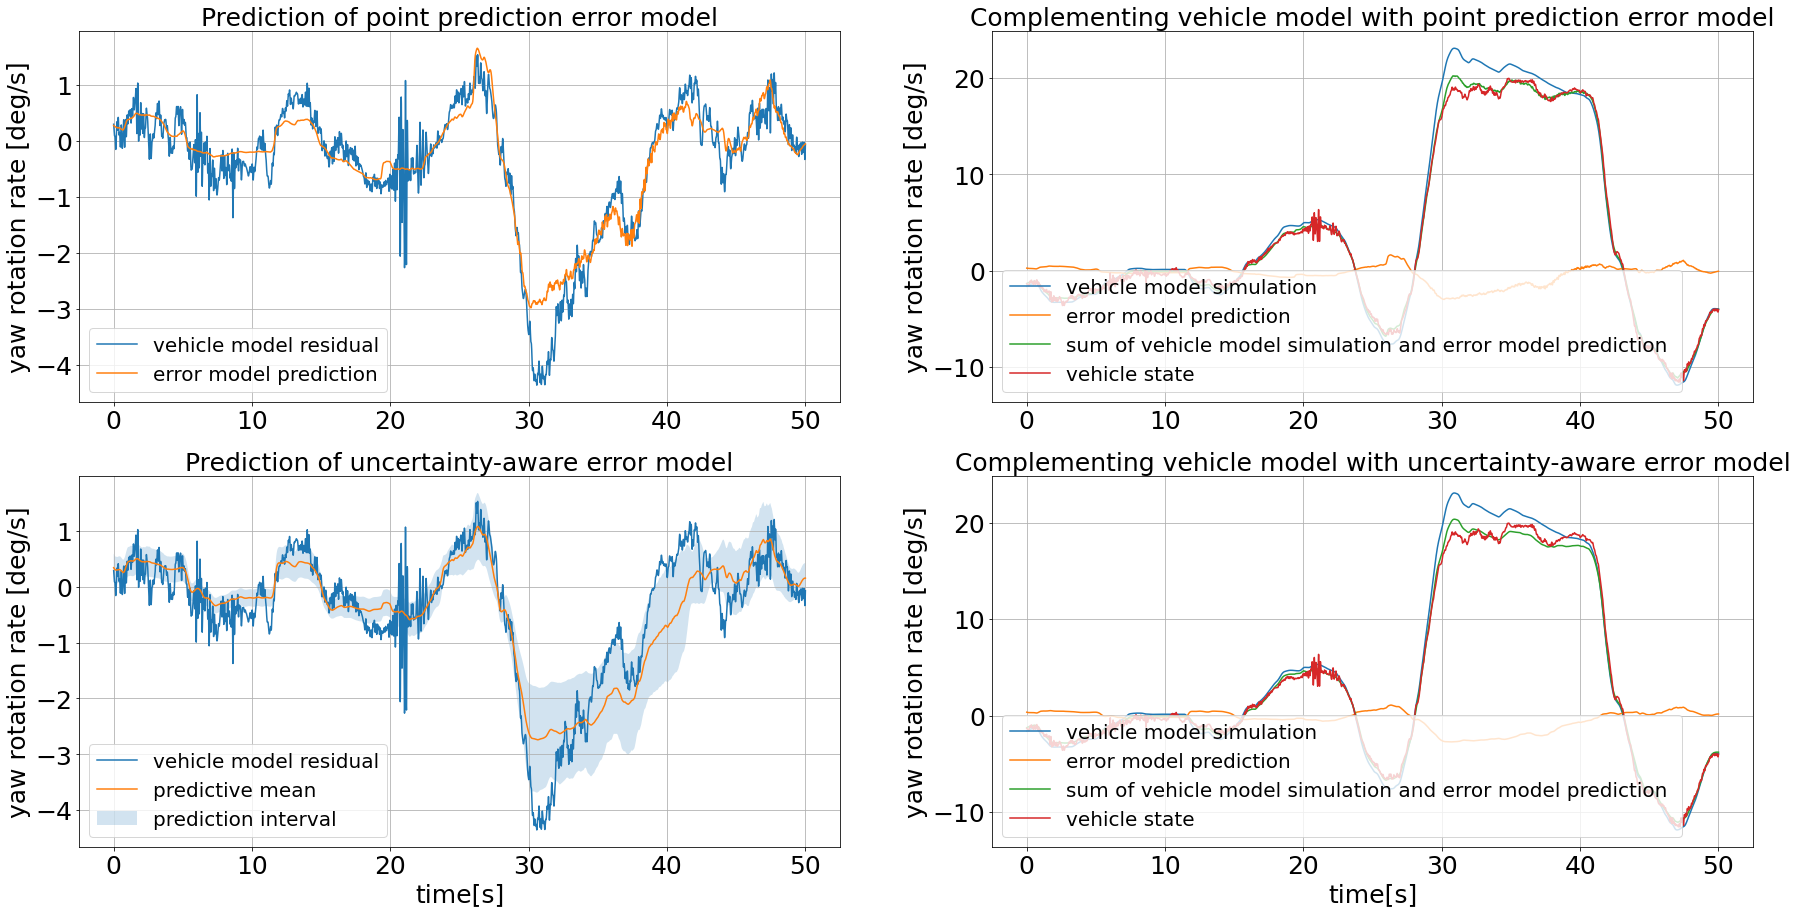

In [104]:
fig,ax=plt.subplots(2,2,figsize=(30,15))
start=10000
end=start+5000
max_=variable_property.loc['max','resRearYWRT[d/s]']
min_=variable_property.loc['min','resRearYWRT[d/s]']
simulation=(testing_inputs[:,11]-new_min)/new_scope*(max_-min_)+min_

pointmodel=pd.read_csv(rnndata_path+'pointmodel_mu.csv').iloc[:,1].values.reshape(-1,1)

ax[0][0].plot(np.linspace(0,50,5000),testing_yawrate_difference[start:end],label='vehicle model residual')
ax[0][0].plot(np.linspace(0,50,5000),pointmodel[start:end],label='error model prediction')
ax[0][0].legend(loc='lower left', prop={'size': 20})
ax[0][0].tick_params(axis='x', labelsize=25)
ax[0][0].tick_params(axis='y', labelsize=25)
#ax[0][0].set_xlabel('time[s]',fontsize=25)
ax[0][0].set_ylabel('yaw rotation rate [deg/s]',fontsize=25)
ax[0][0].set_title('Prediction of point prediction error model',fontsize=25)
ax[0][0].grid()


ax[0][1].plot(np.linspace(0,50,5000),simulation[start:end],label='vehicle model simulation')
ax[0][1].plot(np.linspace(0,50,5000),pointmodel[start:end],label='error model prediction')
ax[0][1].plot(np.linspace(0,50,5000),np.add(pointmodel[start:end,0],simulation[start:end]),label='sum of vehicle model simulation and error model prediction ' )
ax[0][1].plot(np.linspace(0,50,5000),testing_yawrate[start:end],label='vehicle state')
ax[0][1].legend(loc='lower left', prop={'size': 20})
ax[0][1].tick_params(axis='x', labelsize=25)
ax[0][1].tick_params(axis='y', labelsize=25)
#ax[0][1].set_xlabel('time[s]',fontsize=25)
ax[0][1].set_ylabel('yaw rotation rate [deg/s]',fontsize=25)
ax[0][1].set_title('Complementing vehicle model with point prediction error model',fontsize=25)
ax[0][1].grid()

ax[1][0].plot(np.linspace(0,50,5000),testing_yawrate_difference[start:end],label='vehicle model residual')
ax[1][0].plot(np.linspace(0,50,5000),mu[start:end],label='predictive mean')
ax[1][0].fill_between(np.linspace(0,50,5000), mu[start:end] - sigma[start:end].mul(2.58), mu[start:end]+ sigma[start:end].mul(2.58), alpha=0.2, label='prediction interval')
ax[1][0].legend(loc='lower left', prop={'size': 20})
ax[1][0].tick_params(axis='x', labelsize=25)
ax[1][0].tick_params(axis='y', labelsize=25)
ax[1][0].set_xlabel('time[s]',fontsize=25)
ax[1][0].set_ylabel('yaw rotation rate [deg/s]',fontsize=25)
ax[1][0].set_title('Prediction of uncertainty-aware error model',fontsize=25)
ax[1][0].grid()

ax[1][1].plot(np.linspace(0,50,5000),simulation[start:end],label='vehicle model simulation')
ax[1][1].plot(np.linspace(0,50,5000),mu[start:end],label='error model prediction')
ax[1][1].plot(np.linspace(0,50,5000),mu[start:end]+simulation[start:end],label='sum of vehicle model simulation and error model prediction ' )
ax[1][1].plot(np.linspace(0,50,5000),testing_yawrate[start:end],label='vehicle state')
#plt.fill_between(np.linspace(0,50,5000), mu[start:end] - sigma[start:end].mul(3), mu[start:end] + sigma[start:end].mul(3), alpha=0.2, label='prediction interval')
ax[1][1].legend(loc='lower left', prop={'size': 20})
ax[1][1].tick_params(axis='x', labelsize=25)
ax[1][1].tick_params(axis='y', labelsize=25)
ax[1][1].set_xlabel('time[s]',fontsize=25)
ax[1][1].set_ylabel('yaw rotation rate [deg/s]',fontsize=25)
ax[1][1].set_title('Complementing vehicle model with uncertainty-aware error model',fontsize=25)
ax[1][1].grid()
plt.savefig('error_model_results.png')

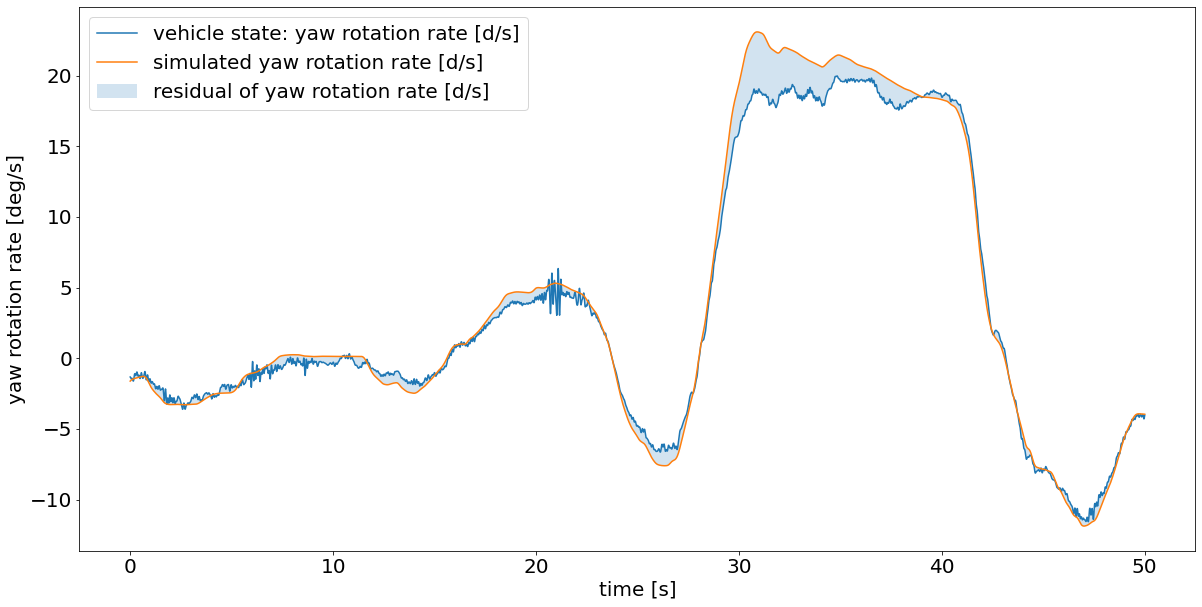

In [9]:
plt.figure(figsize=(20,10))
plt.plot(np.linspace(0,50,5000),testing_yawrate[start:end],label='vehicle state: yaw rotation rate [d/s]')
plt.plot(np.linspace(0,50,5000),simulation[start:end],label='simulated yaw rotation rate [d/s]')

plt.fill_between(np.linspace(0,50,5000),simulation[start:end],testing_yawrate[start:end,0],alpha=0.2,label='residual of yaw rotation rate [d/s]')
plt.legend(prop={'size': 20})
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.xlabel('time [s]', fontdict={'fontsize': 20})
plt.ylabel('yaw rotation rate [deg/s]',fontdict={'fontsize':20})

plt.savefig('simualtion_yawrate.png')

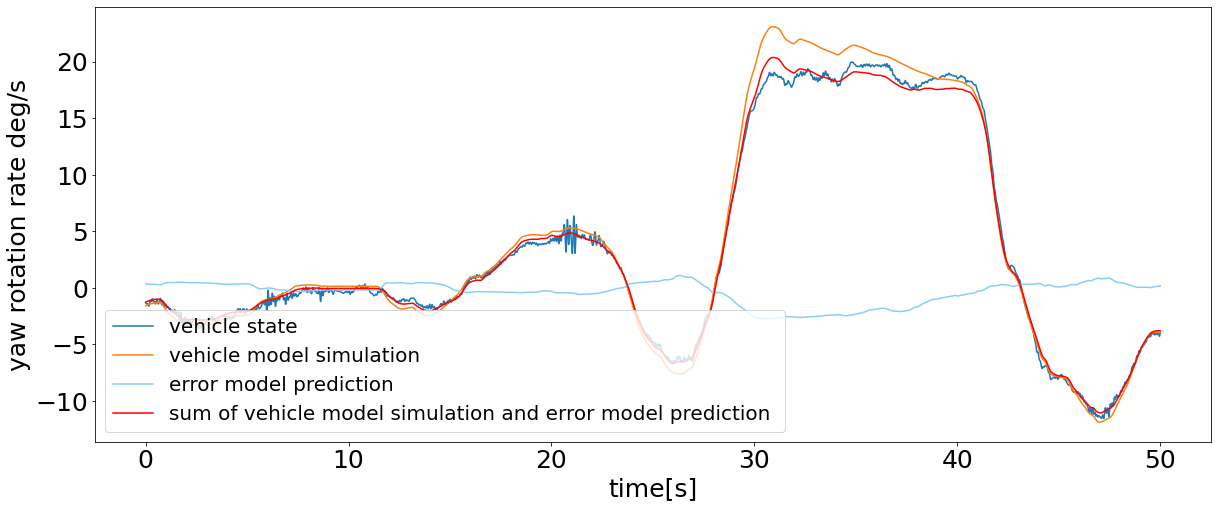

In [13]:
start=10000
end=start+5000
max_=variable_property.loc['max','resRearYWRT[d/s]']
min_=variable_property.loc['min','resRearYWRT[d/s]']
simulation=(testing_inputs[:,11]-new_min)/new_scope*(max_-min_)+min_

plt.figure(figsize=(20,8))
plt.plot(np.linspace(0,50,5000),testing_yawrate[start:end],label='vehicle state')
plt.plot(np.linspace(0,50,5000),simulation[start:end],label='vehicle model simulation')
plt.plot(np.linspace(0,50,5000),mu[start:end],label='error model prediction',color='lightskyblue')
plt.plot(np.linspace(0,50,5000),mu[start:end]+simulation[start:end],label='sum of vehicle model simulation and error model prediction ',color='red' )





#plt.fill_between(np.linspace(0,50,5000), mu[start:end] - sigma[start:end].mul(3), mu[start:end] + sigma[start:end].mul(3), alpha=0.2, label='prediction interval')
plt.legend(loc='lower left', prop={'size': 20})
plt.tick_params(axis='x', labelsize=25)
plt.tick_params(axis='y', labelsize=25)
plt.xlabel('time[s]',fontsize=25)
plt.ylabel('yaw rotation rate deg/s',fontsize=25)
plt.savefig('complement_b')

# Correlation analysis

In [82]:
residual =testing_yawrate_difference- mu
original_residual=testing_yawrate_difference
residual_del5s=residual[samplingFrequency*(m-1):].reshape(-1,1)
original_residual_del5s=original_residual[samplingFrequency*(m-1):].reshape(-1,1)

point_model=pd.read_csv(rnndata_path+'pointmodel_mu.csv').iloc[:,1].values.reshape(-1,1)
residual_point=(testing_yawrate_difference- point_model)[samplingFrequency*(m-1):].reshape(-1,1)

samplingFrequency=10
m=100



In [83]:
combine_past_del5s=[]
inputs_columns=['payloadFraction','steer11','brakePosition[percent]','wheelspeed']
for index,i in enumerate(inputs_columns):
    max_=variable_property.loc['max',i]
    min_=variable_property.loc['min',i]
    testing_inputs[:,index]=(testing_inputs[:,index]-new_min)/new_scope*(max_-min_)+min_
    past_inputs=testing_inputs[samplingFrequency*(m-1):,index]
    for j in range(m-2,-1,-1):
        past_inputs=np.c_[past_inputs, testing_inputs[samplingFrequency*j:len(testing_inputs)-samplingFrequency*(m-1)+samplingFrequency*j,index]]
    print(past_inputs.shape)
    combine_past_del5s.append(past_inputs)     

(179143, 100)
(179143, 100)
(179143, 100)
(179143, 100)


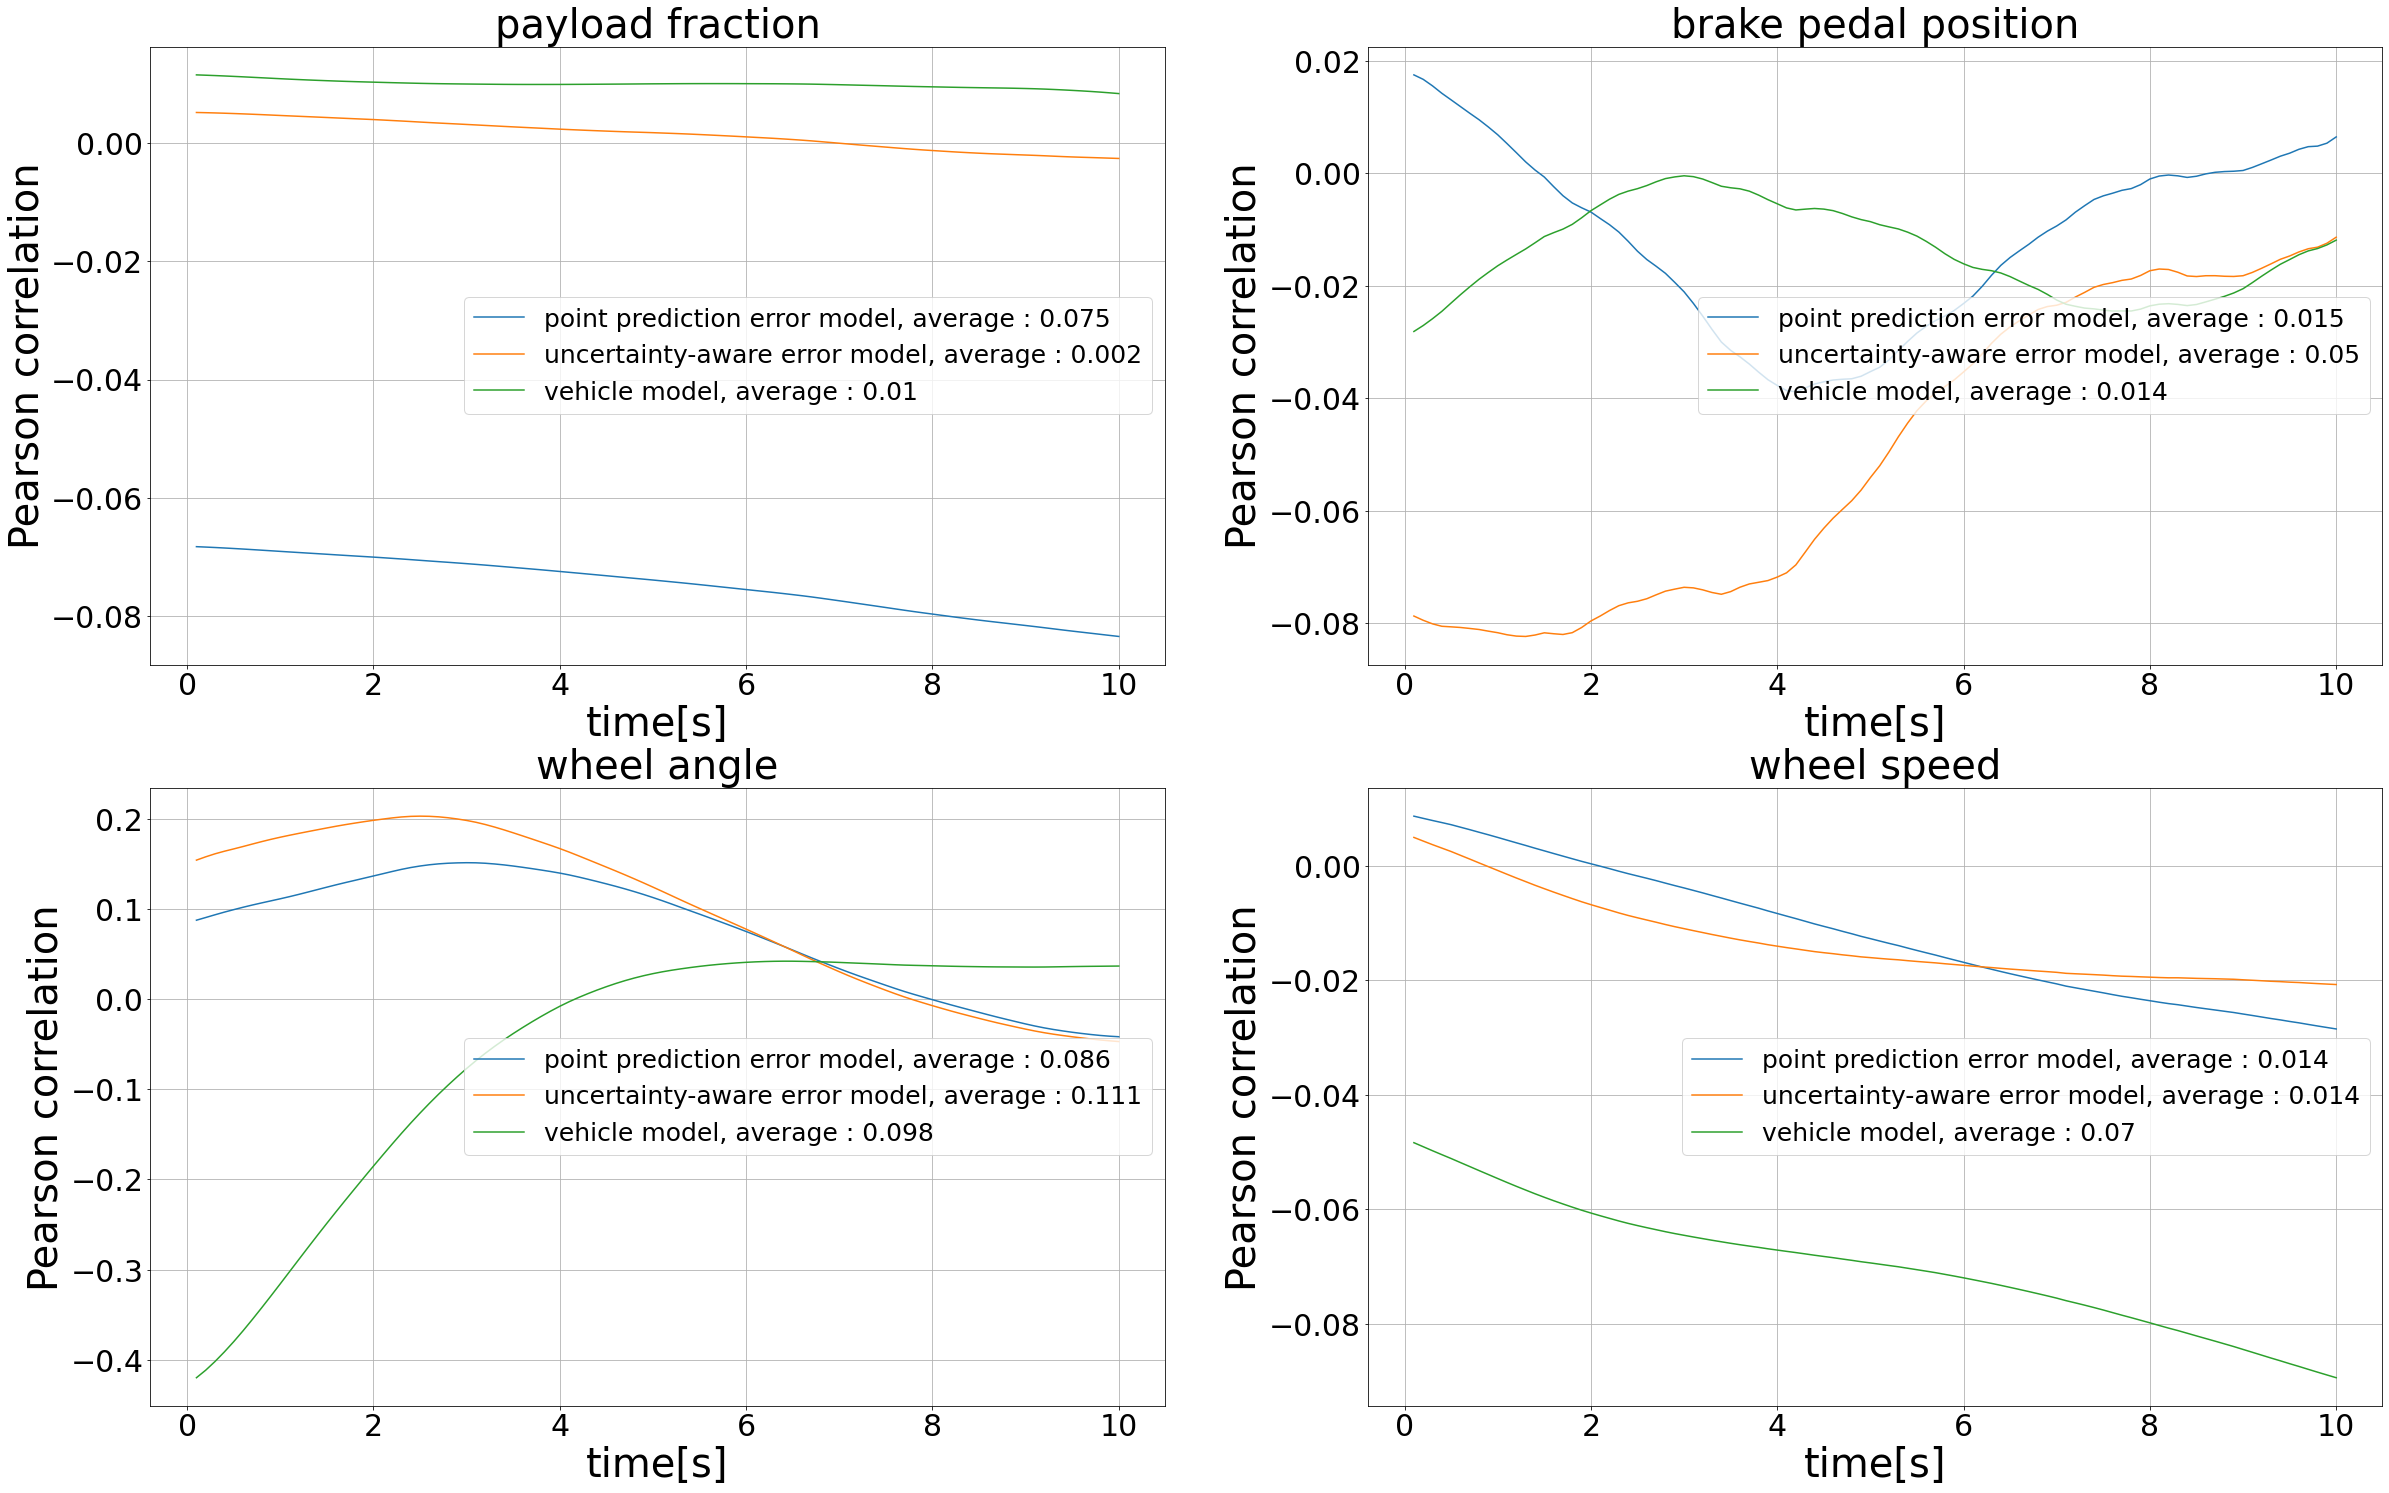

In [91]:
fig,ax=plt.subplots(2,2,figsize=(40,25))
titles=['payload fraction','wheel angle','brake pedal position','wheel speed']
for i in range(4):
    corr_point=np.corrcoef(residual_point,combine_past_del5s[i],rowvar=False)[0,1:]
    corr_uncertainty=np.corrcoef(residual_del5s,combine_past_del5s[i],rowvar=False)[0,1:]
    original_corr=np.corrcoef(original_residual_del5s,combine_past_del5s[i],rowvar=False)[0,1:]

    ax[i%2][i//2].plot(np.linspace(0.1,m/10,m),corr_point,label='point prediction error model, average : '+str(round(np.mean(np.abs(corr_point)),3)))
    ax[i%2][i//2].plot(np.linspace(0.1,m/10,m),corr_uncertainty,label='uncertainty-aware error model, average : '+str(round(np.mean(np.abs(corr_uncertainty)),3)))
    ax[i%2][i//2].plot(np.linspace(0.1,m/10,m),original_corr,label='vehicle model, average : '+str(round(np.mean(np.abs(original_corr)),3)))
    ax[i%2][i//2].legend(loc='center right', prop={'size': 25})
    ax[i%2][i//2].grid()
    ax[i%2][i//2].set_ylabel('Pearson correlation',fontsize=40)
    ax[i%2][i//2].set_xlabel('time[s]',fontsize=40)
    ax[i%2][i//2].tick_params(axis='x', labelsize=30)
    ax[i%2][i//2].tick_params(axis='y', labelsize=30)
    ax[i%2][i//2].set_title(titles[i],fontsize=40)
    plt.savefig('correlation.png')



# Cover rage

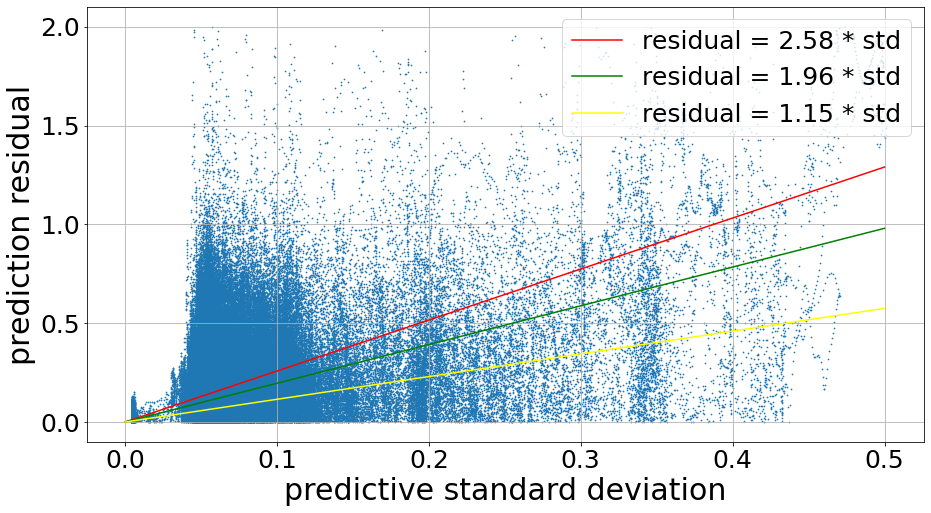

In [77]:
plt.figure(figsize=(15,8))
mu=pd.read_csv(rnndata_path+'/uncertaintymodel_mu.csv')
sigma=pd.read_csv(rnndata_path+'/uncertaintymodel_sigma.csv')
diff=np.abs(testing_yawrate_difference[:, 0] - mu.iloc[:,1].values)
plt.scatter(sigma.iloc[:,1].values[diff<2], diff[diff<2],s=0.5)
plt.plot(np.linspace(0,0.5,10),np.linspace(0,1.29,10),color='red',label='residual = 2.58 * std')
plt.plot(np.linspace(0,0.5,10),np.linspace(0,0.98,10),color='green',label='residual = 1.96 * std')
plt.plot(np.linspace(0,0.5,10),np.linspace(0,0.575,10),color='yellow',label='residual = 1.15 * std')
plt.legend(loc='upper right', prop={'size': 25})
plt.grid()
plt.xlabel('predictive standard deviation',fontsize=30)
plt.ylabel('prediction residual',fontsize=30)
plt.tick_params(axis='x', labelsize=25)
plt.tick_params(axis='y', labelsize=25)
plt.savefig('uncertaintytoresidua.png')